## **PyPPSinflation notebook 4: analytical vs numerical PPS**

Here we compare the numerical and analytical primordial power spectra (PPS). Both types of spectra have been computed in two different notebooks: the first PyPPSinflation notebook and the third one. Therefore, we do not delve into the details here.

For convenience, we will directly use the analytical spectra computed with the $b$s coefficients, which are simpler to manage and more effective in computing the spectral indices and other quantities. Refer to the numerical and analytical scripts for more information.

Additionally, the key focus of this notebook is the renormalization of the coupling constants to ensure that the PPS match at the pivot scale $k_*$. As discussed in previous notebooks, particularly the numerical notebook where the renormalization procedure is well explained, we use different coupling constants for the analytical and numerical calculations. The analytical constants are further split into three: scalar, tensor, and scalar with $\epsilon_4=0$.

Here, we renormalize the previously found coupling constants to achieve matching of all PPS (analytical and numerical, scalar and tensor) at the pivot scale.

**How to use this code to renormalize:** 

In the case of the KKLT model of inflation, our coupling constants are the squared masses. In previous notebooks, we determined four different coupling constant values to ensure that the scalar PPS has a value of $2\times 10^{-9}$ at $k_*$. 

Initially, we set the masses as determined in the previous notebooks. Then we run the notebook and, after computing the analytical and tensor PPS, we calculate the ratios at the pivot scale between the scalar numerical and analytical PPS and between the tensor numerical and analytical PPS. These ratio values are then used to renormalize the analytical masses defined at the beginning. Note that in the case of KKLT, the masses are defined as squared, so the renormalization values should be $(\text{ratio})^{1/2}$.

Once the coupling constants are redefined, you can run the notebook again to obtain all the necessary values and perform all required computations and comparisons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.integrate import odeint #This is a scipy package to solve ode.
from scipy.interpolate import interp1d, interp2d #We want to make an interpolation in order to have not a set of arrays but punctual functions.
from scipy import optimize #this is needed to find the roots of phi (in the case we want to use a script, but better to make it by hand)
from scipy.special import zeta, polygamma, factorial #To import the Reimann Gamma

In [2]:
#Defining model and its parameters.

#MODEL :   M^4 (1+mu/\phi)^-1

Mpl=1
mu=1

#Values found in the previous notebooks.  (---)**(1/2) are the renormalization factors.
#Please, at the first run, just put (1)**(1/2) for the analytical masses. 
#The numerical mass have already been renormalized twice, to ensure higher sensitivity.
#Then, compute the ratios between the analytical and numerical PPS (see below)
#and change the analytical renomalization factors as (ratio)**(1/2). 

m2an_s=(1.0000010723939756)**(1/2) * 1.7399076640210377e-05
m2an_t=(1.0222578515248386)**(1/2) * 1.7399076640210377e-05
m2an_s_noeps4 = (1.000001076552317)**(1/2) * 1.739907869677529e-05
m2num=(1.0000003043931327*1.0234237922139249)**(1/2)*1.7399076640210377e-05

# Analytical PPS

In [3]:
# After athe analytical computations (see the 2nd notebook), we have the following epsilon_i for KKLT:

def eps1(N):      
    eps1 = 8 * ( mu )**( 2 ) * ( ( ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + 
-1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 
)**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * 
mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu 
* ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 1/3 
) + mu * ( -1 + mu * ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * 
mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 
1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 
12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 
2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( -1/3 ) ) 
) )**( -4 ) * ( ( 1 + 2 * mu * ( ( ( ( 12 * N * mu + ( ( ( 2 
)**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 
1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + 
-3 * mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * 
mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) 
) )**( 1/3 ) + mu * ( -1 + mu * ( ( 12 * N * mu + ( ( ( 2 )**( 
1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 
) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * 
mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) 
* ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) 
)**( -1/3 ) ) ) )**( -1 ) ) )**( -2 )
    return eps1

def eps2(N):
    eps2 = 32 * mu * ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * 
( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( 
mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * 
( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 
1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) * ( ( mu )**( 2 ) + ( ( 12 
* N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 
2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( 
( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 6 * N + 
( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) 
)**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) ) * ( ( ( mu )**( 2 ) + ( -1 
* mu * ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( 
mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu 
)**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 
6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 
) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 1/3 ) + ( ( 12 * N * 
mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 
) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 
)**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 
1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) 
)**( 1/2 ) ) ) )**( 2/3 ) ) ) )**( -2 ) * ( ( ( mu )**( 2 ) + ( mu * 
( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 
2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 
) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 6 * 
N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 1/3 ) + ( ( 12 * N * mu 
+ ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 
1/2 ) + -3 * mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 
) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) 
)**( 1/2 ) ) ) )**( 2/3 ) ) ) )**( -2 )
    return eps2

def eps3(N):
    eps3= -8 * mu * ( -12 * N * mu + ( -1 * ( 2 )**( 1/2 ) * mu * ( mu * ( 
2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( ( mu )**( 2 ) * ( mu * ( 2 * 
( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + -1 * ( 2 )**( 1/2 ) * ( ( mu )**( 
2 ) * ( 72 * ( N )**( 2 ) + ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * 
mu + 12 * N * ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 
)**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) ) * ( ( ( mu )**( 2 ) 
+ ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * 
( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 
2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 6 * 
N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) ) )**( -1 ) * ( ( ( mu 
)**( 2 ) + ( -1 * mu * ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 
* mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 
)**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * 
mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu 
* ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 1/3 
) + ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu 
* ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu 
)**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 
6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 
) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) ) ) )**( -2 ) * ( ( 
( mu )**( 2 ) + ( mu * ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 
* mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 
)**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * 
mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu 
* ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 1/3 
) + ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu 
* ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu 
)**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 
6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 
) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) ) ) )**( -2 ) * ( 3 
* ( mu )**( 4 ) + ( 3 * mu * ( 12 * N + ( 2 )**( 1/2 ) * ( mu * 
( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) * ( ( 12 * N * mu + ( ( 
2 )**( 1/2 ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 
-1 * ( mu )**( 2 ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + 
( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( 72 * ( N )**( 2 ) + ( ( 2 * 
( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( ( 2 )**( 1/2 ) + -1 
* mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) 
) ) ) )**( 1/3 ) + ( 3 * ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( 72 * ( 
N )**( 2 ) + ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * 
N * ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) ) ) )**( 1/2 ) * ( ( 12 * N * mu + ( ( 2 )**( 
1/2 ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( -1 * ( 
mu )**( 2 ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 
)**( 1/2 ) * ( ( mu )**( 2 ) * ( 72 * ( N )**( 2 ) + ( ( 2 * ( 2 
)**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( ( 2 )**( 1/2 ) + -1 * 
mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) 
) ) )**( 1/3 ) + -1 * ( mu )**( 2 ) * ( 3 * ( mu * ( 2 * ( 2 )**( 1/2 
) + mu ) )**( 1/2 ) * ( ( 12 * N * mu + ( ( 2 )**( 1/2 ) * mu * 
( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( -1 * ( mu )**( 2 ) 
* ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( 
( mu )**( 2 ) * ( 72 * ( N )**( 2 ) + ( ( 2 * ( 2 )**( 1/2 ) + 
-3 * mu ) * mu + 12 * N * ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * 
( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) ) )**( 1/3 
) + -7 * ( ( 12 * N * mu + ( ( 2 )**( 1/2 ) * mu * ( mu * ( 2 * 
( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( -1 * ( mu )**( 2 ) * ( mu * ( 2 
* ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) 
* ( 72 * ( N )**( 2 ) + ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu 
+ 12 * N * ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 
1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) ) )**( 2/3 ) ) ) ) )
    return eps3

def eps4(N):
    eps4= -8 * ( mu )**( 2 ) * ( -12 * N * mu + ( -1 * ( 2 )**( 1/2 ) * 
mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( ( mu )**( 2 ) 
* ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + -1 * ( 2 )**( 1/2 ) 
* ( ( mu )**( 2 ) * ( 72 * ( N )**( 2 ) + ( ( 2 * ( 2 )**( 1/2 ) 
+ -3 * mu ) * mu + 12 * N * ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu 
* ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) ) * ( ( ( 
mu )**( 2 ) + ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * 
mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * 
( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * 
N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 
2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) ) )**( 
-1 ) * ( ( ( mu )**( 2 ) + ( -1 * mu * ( ( 12 * N * mu + ( ( ( 2 
)**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 
1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + 
-3 * mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * 
mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) 
) )**( 1/3 ) + ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) 
* mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) 
* ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * 
N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 
2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) ) ) )**( 
-2 ) * ( ( ( mu )**( 2 ) + ( mu * ( ( 12 * N * mu + ( ( ( 2 )**( 
1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 
) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * 
mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) 
* ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) 
)**( 1/3 ) + ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * 
mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * 
( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * 
N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 
2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) ) ) )**( 
-2 ) * ( 12672 * ( N )**( 2 ) * ( mu )**( 3 ) + ( 352 * ( 2 )**( 
1/2 ) * ( mu )**( 4 ) + ( -528 * ( mu )**( 5 ) + ( 53 * ( mu )**( 7 ) 
+ ( 2112 * ( 2 )**( 1/2 ) * N * ( mu )**( 3 ) * ( mu * ( 2 * ( 2 
)**( 1/2 ) + mu ) )**( 1/2 ) + ( -2112 * N * ( mu )**( 4 ) * ( 
mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 1056 * ( 2 )**( 1/2 ) 
* N * ( mu )**( 2 ) * ( ( mu )**( 2 ) * ( 72 * ( N )**( 2 ) 
+ ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( ( 2 )**( 
1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) 
)**( 1/2 ) + ( 176 * ( mu )**( 2 ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu 
) )**( 1/2 ) * ( ( mu )**( 2 ) * ( 72 * ( N )**( 2 ) + ( ( 2 * ( 
2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( ( 2 )**( 1/2 ) + -1 * 
mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) + 
( -88 * ( 2 )**( 1/2 ) * ( mu )**( 3 ) * ( mu * ( 2 * ( 2 )**( 1/2 ) 
+ mu ) )**( 1/2 ) * ( ( mu )**( 2 ) * ( 72 * ( N )**( 2 ) + ( ( 
2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( ( 2 )**( 1/2 ) 
+ -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 
1/2 ) + ( 828 * N * ( mu )**( 4 ) * ( ( 12 * N * mu + ( ( ( 
2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) 
)**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 
) + -3 * mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + 
-1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 
1/2 ) ) ) )**( 1/3 ) + ( 69 * ( 2 )**( 1/2 ) * ( mu )**( 4 ) * ( mu * 
( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) * ( ( 12 * N * mu + ( ( ( 
2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) 
)**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 
) + -3 * mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + 
-1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 
1/2 ) ) ) )**( 1/3 ) + ( -69 * ( mu )**( 5 ) * ( mu * ( 2 * ( 2 )**( 
1/2 ) + mu ) )**( 1/2 ) * ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + 
-1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 
)**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * 
mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu 
* ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 1/3 
) + ( 69 * ( 2 )**( 1/2 ) * ( mu )**( 3 ) * ( ( mu )**( 2 ) * ( 72 * 
( N )**( 2 ) + ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * 
N * ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) ) ) )**( 1/2 ) * ( ( 12 * N * mu + ( ( ( 2 )**( 
1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 
) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * 
mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) 
* ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) 
)**( 1/3 ) + ( 2592 * ( N )**( 2 ) * mu * ( ( 12 * N * mu + 
( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 
1/2 ) + -3 * mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 
) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) 
)**( 1/2 ) ) ) )**( 2/3 ) + ( 72 * ( 2 )**( 1/2 ) * ( mu )**( 2 ) * ( 
( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 2 
* ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) 
* ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 6 * 
N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) + ( -108 * ( mu )**( 3 
) * ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu 
* ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu 
)**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 
6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 
) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) + ( 53 * ( mu )**( 
5 ) * ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( 
mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu 
)**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 
6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 
) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) + ( 432 * ( 2 )**( 
1/2 ) * N * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) * 
( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 
2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 
) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 6 * 
N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) + ( -432 * N * ( 
mu )**( 2 ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) * ( ( 12 
* N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 
2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( 
( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 6 * N + 
( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) 
)**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) + ( 216 * ( 2 )**( 1/2 ) * 
N * ( ( mu )**( 2 ) * ( 72 * ( N )**( 2 ) + ( ( 2 * ( 2 
)**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( ( 2 )**( 1/2 ) + -1 * 
mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) * 
( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 
2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 
) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 6 * 
N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) + ( 36 * ( mu * ( 2 * ( 
2 )**( 1/2 ) + mu ) )**( 1/2 ) * ( ( mu )**( 2 ) * ( 72 * ( N 
)**( 2 ) + ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 
( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 
1/2 ) ) ) )**( 1/2 ) * ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 
* mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 
)**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * 
mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu 
* ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 
) + -18 * ( 2 )**( 1/2 ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) 
)**( 1/2 ) * ( ( mu )**( 2 ) * ( 72 * ( N )**( 2 ) + ( ( 2 * ( 2 
)**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( ( 2 )**( 1/2 ) + -1 * 
mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) * 
( ( 12 * N * mu + ( ( ( 2 )**( 1/2 ) + -1 * mu ) * mu * ( mu * ( 
2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 
) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * N * ( 6 * 
N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( 2/3 ) ) ) ) ) ) ) ) ) ) ) ) ) 
) ) ) ) ) ) ) ) ) * ( ( 3 * ( mu )**( 4 ) + ( 3 * mu * ( 12 * N 
+ ( 2 )**( 1/2 ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) * 
( ( 12 * N * mu + ( ( 2 )**( 1/2 ) * mu * ( mu * ( 2 * ( 2 )**( 
1/2 ) + mu ) )**( 1/2 ) + ( -1 * ( mu )**( 2 ) * ( mu * ( 2 * ( 2 
)**( 1/2 ) + mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( 
72 * ( N )**( 2 ) + ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 
* N * ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) 
+ mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) ) )**( 1/3 ) + ( 3 * ( 2 )**( 
1/2 ) * ( ( mu )**( 2 ) * ( 72 * ( N )**( 2 ) + ( ( 2 * ( 2 )**( 
1/2 ) + -3 * mu ) * mu + 12 * N * ( ( 2 )**( 1/2 ) + -1 * mu ) * 
( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) * ( ( 12 
* N * mu + ( ( 2 )**( 1/2 ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) + ( -1 * ( mu )**( 2 ) * ( mu * ( 2 * ( 2 )**( 1/2 ) 
+ mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( 72 * ( 
N )**( 2 ) + ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * 
N * ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) ) )**( 1/3 ) + -1 * ( mu )**( 2 ) 
* ( 3 * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) * ( ( 12 * 
N * mu + ( ( 2 )**( 1/2 ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) + ( -1 * ( mu )**( 2 ) * ( mu * ( 2 * ( 2 )**( 1/2 ) 
+ mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( 72 * ( 
N )**( 2 ) + ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * 
N * ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) ) )**( 1/3 ) + -7 * ( ( 12 * 
N * mu + ( ( 2 )**( 1/2 ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) + ( -1 * ( mu )**( 2 ) * ( mu * ( 2 * ( 2 )**( 1/2 ) 
+ mu ) )**( 1/2 ) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( 72 * ( 
N )**( 2 ) + ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) * mu + 12 * 
N * ( ( 2 )**( 1/2 ) + -1 * mu ) * ( mu * ( 2 * ( 2 )**( 1/2 ) + 
mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) ) )**( 2/3 ) ) ) ) ) )**( -1 )
    return eps4

#Comment if you want eps4(N) different from 0
#def eps4(N):
#    eps4=0 
#    return eps4

In [4]:
#definining deltaN_star = 55 efolds. It is the same choice we made in the numerical script.

deltaN_star = 55

In [5]:
#Interval of integration in k. The same as the numerical script.

k_star= 0.05
k_num = 94
k_win = np.logspace(-5, 3, k_num)

In [6]:
#Defining the Hubble function at the first order, second, and third-order (it is always the same)

def H_sq1(mass,N):
    H_sq = 1/3 * (mass)**2 * ( ( 1 + 2 * mu * ( ( ( ( 12 * N * mu + ( ( ( 2 )**( \
1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 \
) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * \
mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) \
* ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) \
)**( 1/3 ) + mu * ( -1 + mu * ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 \
) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + \
( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) \
* mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( \
mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( \
-1/3 ) ) ) )**( -1 ) ) )**( -1 )
    return H_sq

def H_sq2(mass,N):
    H_sq2 = 1/3 * (mass)**2 * ( ( 1 + 2 * mu * ( ( ( ( 12 * N * mu + ( ( ( 2 )**( \
1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 \
) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * \
mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) \
* ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) \
)**( 1/3 ) + mu * ( -1 + mu * ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 \
) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + \
( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) \
* mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( \
mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( \
-1/3 ) ) ) )**( -1 ) ) )**( -1 )
    return H_sq2

def H_sq3(mass,N):
    H_sq3 = 1/3 * (mass)**2 * ( ( 1 + 2 * mu * ( ( ( ( 12 * N * mu + ( ( ( 2 )**( \
1/2 ) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 \
) + ( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * \
mu ) * mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) \
* ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) \
)**( 1/3 ) + mu * ( -1 + mu * ( ( 12 * N * mu + ( ( ( 2 )**( 1/2 \
) + -1 * mu ) * mu * ( mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) + \
( 2 )**( 1/2 ) * ( ( mu )**( 2 ) * ( ( 2 * ( 2 )**( 1/2 ) + -3 * mu ) \
* mu + 12 * N * ( 6 * N + ( ( 2 )**( 1/2 ) + -1 * mu ) * ( \
mu * ( 2 * ( 2 )**( 1/2 ) + mu ) )**( 1/2 ) ) ) )**( 1/2 ) ) ) )**( \
-1/3 ) ) ) )**( -1 ) ) )**( -1 )
    return H_sq3

In [7]:
#Defining the P0s at the first, second, and third-order (they are always the same)

P0_s1 = H_sq1(m2an_s,deltaN_star)/(8*np.pi**2 * Mpl**2 *  eps1(deltaN_star))

P0_t1 = 2*H_sq1(m2an_t,deltaN_star)/(np.pi**2 * Mpl**2)

P0_s2 = H_sq2(m2an_s,deltaN_star)/(8*np.pi**2 * Mpl**2 *  eps1(deltaN_star))

P0_t2 = 2*H_sq2(m2an_t, deltaN_star)/(np.pi**2 * Mpl**2)

P0_s3 = H_sq3(m2an_s,deltaN_star)/(8*np.pi**2 * Mpl**2 *  eps1(deltaN_star))

P0_s3_noep4 = H_sq3(m2an_s_noeps4,deltaN_star)/(8*np.pi**2 * Mpl**2 *  eps1(deltaN_star))

P0_t3 = 2*H_sq3(m2an_t, deltaN_star)/(np.pi**2 * Mpl**2)


In [8]:
#Defining the b parameters at first, second, and third-order 

C = -0.7296

def bs01(N):
    return -2*(C+1)*eps1(N) - C*eps2(N)

def bs11(N):
    return -2*eps1(N) - eps2(N) 

def bs21(N):
    return 0

def bt01(N): 
    return -2*(C+1)*eps1(N)

def bt11(N):
    return -2*eps1(N)

def bt21(N):
    return 0

def bs02(N): 
    return -2*(C+1)*eps1(N) - C*eps2(N) + (-2*C + 0.5*np.pi**2 -7)*eps1(N)**2 + (-C**2 - 3*C + 7/12* np.pi**2 -7)*eps1(N)*eps2(N) + ( np.pi**2/8 -1)*eps2(N)**2 + (-0.5*C**2 + np.pi**2/24)*eps2(N)*eps3(N)

def bs12(N): 
    return -2*eps1(N) - eps2(N) + -2*eps1(N)**2 - (2*C+3)*eps1(N)*eps2(N)  - C*eps2(N)*eps3(N)

def bs22(N):
    return -2*eps1(N)*eps2(N)-eps2(N)*eps3(N)

def bt02(N):
    return -2*(C+1)*eps1(N) + (-2*C + 0.5*np.pi**2 -7)*eps1(N)**2 + (-C**2 -2*C + np.pi**2/12 -2)*eps1(N)*eps2(N)

def bt12(N):
    return -2*eps1(N) -2*eps1(N)**2- 2*(C+1)*eps1(N)*eps2(N)

def bt22(N):
    return   - 2*eps1(N)*eps2(N)

def bs03(N, e4=True):
    if e4:
        epsi4 = eps4(N)
    else:
        epsi4=0
    return (-2 * (1 + C) * eps1(N) + (-5 - 2 * C + (np.pi**2) / 2) * eps1(N)**2 - C * eps2(N) + (-6 - 3 * C - C**2 + (7 * np.pi**2) / 12) * eps1(N) * eps2(N)+ (1 / 24) * (-12 * C**2 + np.pi**2) * eps2(N) * eps3(N) - (1 / 24) * (80 + 48 * C - 24 * np.pi**2 + 112 * zeta(3)) * eps1(N)**3 + (1 / 8) * (-8 + np.pi**2) * eps2(N)**2  - (1 / 24) * (-16 + 14 * zeta(3)) * eps2(N)**3 + (1 / 12) * (-144 - 180 * C - 36 * C**2 + 27 * np.pi**2 + 12 * C * np.pi**2 - 84 * zeta(3)) * eps1(N)**2 * eps2(N)- (1 / 24) * (64 + 168 * C + 36 * C**2 + 8 * C**3 - 21 * np.pi**2 - 14 * C * np.pi**2 + 100 * zeta(3)) * eps1(N) * eps2(N)**2+ (1 / 24) * (16 - 4 * C**3 + C * np.pi**2 - 8 * zeta(3)) * (eps2(N) * eps3(N)**2 + eps2(N) * eps3(N) * epsi4)  + (1 / 24) * (-48 * C + 6 * C * np.pi**2) * eps2(N)**2 * eps3(N)+ (1 / 12) * (-8 - 72 * C - 24 * C**2 - 4 * C**3 + 2 * np.pi**2 + 7 * C * np.pi**2 - 8 * zeta(3)) * eps1(N) * eps2(N) * eps3(N))


def bs13(N, e4=True):
    if e4:
        epsi4 = eps4(N)
    else:
        epsi4=0
    return (-2 * eps1(N) - 2 * eps1(N)**2 - 2 * eps1(N)**3 - eps2(N) - (3 + 2 * C) * eps1(N) * eps2(N) - C * eps2(N) * eps3(N) - (2 / 3) * (45 / 2 + 9 * C - 3 * np.pi**2 / 2) * eps1(N)**2 * eps2(N)- (1 / 4) * (28 + 12 * C + 4 * C**2 - 7 * np.pi**2 / 3) * eps1(N) * eps2(N)**2 + (1 / 2) * (-12 - 8 * C - 2 * C**2 + 7 * np.pi**2 / 6) * eps1(N) * eps2(N) * eps3(N)+ (1 / 24) * (-12 * C**2 + np.pi**2) * (eps2(N) * eps3(N)**2 + eps2(N) * eps3(N) * epsi4) + (1 / 24) * (-48 + 6 * np.pi**2) * eps2(N)**2 * eps3(N))


def bs23(N, e4=True):
    if e4:
        epsi4 = eps4(N)
    else:
        epsi4=0
    return (-2 * eps1(N) * eps2(N) - 6 * eps1(N)**2 * eps2(N) - (3 + 2 * C) * eps1(N) * eps2(N)**2 - eps2(N) * eps3(N)- 2 * (2 + C) * eps1(N) * eps2(N) * eps3(N) - C * eps2(N) * eps3(N)**2 - C * eps2(N) * eps3(N) * epsi4)


def bs33(N, e4=True):
    if e4:
        epsi4 = eps4(N)
    else:
        epsi4=0
    return  (-2 * eps1(N) * eps2(N)**2 - 2 * eps1(N) * eps2(N) * eps3(N) - eps2(N) * eps3(N)**2 - eps2(N) * eps3(N) * epsi4)


def bt03(N):
    return (-2 * (1 + C) * eps1(N) + (1 / 2) * (-10 - 4 * C + np.pi**2) * eps1(N)**2  + (1 / 12) * (-24 - 24 * C - 12 * C**2 + np.pi**2) * eps1(N) * eps2(N) - (1 / 3) * (10 + 6 * C - 3 * np.pi**2 + 14 * zeta(3)) * eps1(N)**3  + (1 / 12) * (-144 - 168 * C - 36 * C**2 + 15 * np.pi**2 + 12 * C * np.pi**2) * eps1(N)**2 * eps2(N) - (1 / 12) * (8 + 24 * C + 12 * C**2 + 4 * C**3 - np.pi**2 - C * np.pi**2 + 8 * zeta(3)) * (eps1(N) * eps2(N)**2 + eps1(N) * eps2(N) * eps3(N)))


def bt13(N):
    return (-2 * eps1(N) - 2 * eps1(N)**2 + (-2 - 2 * C) * eps1(N) * eps2(N) - 2 * eps1(N)**3  + (1 / 6) * (-84 - 36 * C + 6 * np.pi**2) * eps1(N)**2 * eps2(N) + (1 / 12) * (-24 - 24 * C - 12 * C**2 + np.pi**2) * (eps1(N) * eps2(N)**2 + eps1(N) * eps2(N) * eps3(N)))


def bt23(N):
    return (-2 * eps1(N) * eps2(N) - 6 * eps1(N)**2 * eps2(N) - 2 * (1 + C) * eps1(N) * eps2(N)**2 - 2 * (1 + C) * eps1(N) * eps2(N) * eps3(N))

def bt33(N):
    return (-2 * eps1(N) * eps2(N)**2 - 2 * eps1(N) * eps2(N) * eps3(N))

In [9]:
#Scalar PPS at first, second, and third-order:

def loggPS_s1(ka):
    log = np.log(ka/k_star)
    loggPS_s_val1 = P0_s1*np.exp((bs01(deltaN_star) + bs11(deltaN_star)*log))
    return loggPS_s_val1

def loggPS_s2(ka): 
    log = np.log(ka/k_star)
    log_sq = log**2
    loggPS_s_val2  = P0_s2*np.exp((bs02(deltaN_star) + bs12(deltaN_star)*log + 0.5*bs22(deltaN_star)*log_sq))
    return loggPS_s_val2

def loggPS_s3(ka): 
    log = np.log(ka/k_star)
    log_sq = log**2
    log_cub = log**3
    loggPS_s_val3  = P0_s3*np.exp((bs03(deltaN_star) + bs13(deltaN_star)*log + 0.5*bs23(deltaN_star)*log_sq+(1/6)*bs33(deltaN_star)*log_cub))
    return loggPS_s_val3

def loggPS_s3_noeps4(ka): 
    log = np.log(ka/k_star)
    log_sq = log**2
    log_cub = log**3
    loggPS_s_val3  = P0_s3_noep4*np.exp((bs03(deltaN_star, False) + bs13(deltaN_star, False)*log + 0.5*bs23(deltaN_star, False)*log_sq+(1/6)*bs33(deltaN_star, False)*log_cub))
    return loggPS_s_val3

In [10]:
#Tensor PPS at first, second, and third-order:

def loggPS_t1(ka):
    log = np.log(ka/k_star)
    log_sq = log**2
    loggPS_t_val1  = P0_t1*np.exp((bt01(deltaN_star) + bt11(deltaN_star)*log))
    return loggPS_t_val1

def loggPS_t2(ka):
    log = np.log(ka/k_star)
    log_sq = log**2
    loggPS_t_val2  = P0_t2*np.exp((bt02(deltaN_star) + bt12(deltaN_star)*log + 0.5*bt22(deltaN_star)*log_sq))
    return loggPS_t_val2

def loggPS_t3(ka):
    log = np.log(ka/k_star)
    log_sq = log**2
    log_cub = log**3
    loggPS_t_val3  = P0_t2*np.exp((bt03(deltaN_star) + bt13(deltaN_star)*log + 0.5*bt23(deltaN_star)*log_sq+(1/6)*bt33(deltaN_star)*log_cub))
    return loggPS_t_val3

# Numerical PPS

In [11]:
#Defining the model 

def V(phi):
    return m2num**2 * (1+mu/phi)**(-1)

def dV(phi):
    return (m2num**2 *mu)/((mu+phi)**2)

In [12]:
# Initial condition for the background

phi_0 = 6* Mpl
phi0_N = -dV(phi_0)/V(phi_0) #-0.1
psi_0 =  np.sqrt (2.0 * V(phi_0)) * phi0_N / np.sqrt(6.0 - phi0_N**2)

IC_bkg = [phi_0, psi_0]

In [13]:
# Solving the background from N_start to N_stop with N_iter steps

N_start = 0
N_stop = 100
N_iter = 10000

N_bkg = np.zeros(N_iter)
N_bkg = np.linspace(N_start, N_stop, N_iter)


def diff_bkg(S, N): 
    phi, psi = S
    return [psi / np.sqrt(1 / 3.0 * (1 / 2 * psi**2 + V(phi))), 
          -3 * psi - dV(phi) / np.sqrt(1 / 3.0 * (1 / 2 * psi**2 + V(phi)))]

sol_bkg = np.zeros(N_iter)
sol_bkg = odeint(diff_bkg, IC_bkg, N_bkg)

phi_bkg = np.zeros(N_iter)
psi_bkg = np.zeros(N_iter)

phi_bkg = sol_bkg[:,0]
psi_bkg = sol_bkg[:,1]

/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_1833/863173537.py:13: RuntimeWarning: invalid value encountered in sqrt
  return [psi / np.sqrt(1 / 3.0 * (1 / 2 * psi**2 + V(phi))),
/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_1833/863173537.py:14: RuntimeWarning: invalid value encountered in sqrt
  -3 * psi - dV(phi) / np.sqrt(1 / 3.0 * (1 / 2 * psi**2 + V(phi)))]


In [14]:
# phi_N = dphi/dN
dphi_array = []
dphi_array = psi_bkg / np.sqrt(1 / 3.0 * (1 / 2 * psi_bkg**2 + V(phi_bkg)))

# phi_NN = d^2phi/dN^2
ddphi_array = []
ddphi_array = np.gradient(dphi_array, N_bkg)

# phi_NNN = d^3phi/dN^3
dddphi_array = []
dddphi_array = np.gradient(ddphi_array, N_bkg)

eps1_array = []
eps1_array = 0.5 * dphi_array**2

eps2_array = []
eps2_array = 2 * ddphi_array / dphi_array

eps3_array = []
eps3_array = dddphi_array / ddphi_array - ddphi_array / dphi_array

dH_array = []
dH_array = np.gradient(np.sqrt(1 / 3.0 * (1 / 2 * psi_bkg**2 + V(phi_bkg))), N_bkg)

In [15]:
# def. interpolation functions

phi_interp = interp1d(N_bkg, phi_bkg, kind='linear')
psi_interp = interp1d(N_bkg, psi_bkg, kind='linear')

Hubble_interp = interp1d(N_bkg, np.sqrt(1 / 3.0 * (1 / 2 * psi_bkg**2 + V(phi_bkg))), kind='linear')
dHubble_interp = interp1d(N_bkg, dH_array, kind='linear')

eps1n = interp1d(N_bkg, eps1_array, kind='linear')
eps2n = interp1d(N_bkg, eps2_array, kind='linear')
eps3n = interp1d(N_bkg, eps3_array, kind='linear')

In [16]:
# Looking for end of inflation: when eps1 =1

Nk = 55

for i in range(N_iter):
    if (eps1_array[i] - 1 > 1e-20):
        N_end = N_bkg[i]
        print("Nend =", N_end)
        break

N_star = N_end - Nk
print("Nstar =", N_star)

Nend = 91.20912091209121
Nstar = 36.20912091209121


In [17]:
#We fix N_* to k_* = 0.06875 h Mpc^-1=0.05 Mpc^-1. 

#dN = dln(a), then it can be a a = a_end e^{N-Nend} or a = a_in e^N

N_ini = 0
aini = k_star / np.exp(N_star-N_ini) / Hubble_interp(N_star)
aend = k_star / np.exp(N_star-N_end) / Hubble_interp(N_star)

print(aini, aend)

1.014307517849476e-12 4.1475110882448726e+27


In [18]:
#Definition of a(N):

def aN(N):
    return aini * np.exp(N)
    #return aend * np.exp(N-N_end) #In the case we choose the other way to express a

#Definitions of zeta for scalar and tensor: 

# scalar
def zeta_r(N):
    return (aN(N) * Hubble_interp(N))**2 * (2 - eps1n(N) + 1.5 * eps2n(N) - eps1n(N) * eps2n(N) / 2 + eps2n(N)**2 / 4 + eps2n(N)*eps3n(N) / 2)

# tensor
def zeta_t(N):
    return 2 * (aN(N) * Hubble_interp(N))**2 + aN(N)**2 * Hubble_interp(N) * dHubble_interp(N)

In [19]:
#N_bounds(k,N) gives the interval of integration for the given k.

def N_bounds(k, N):
    horizon = aN(N) * Hubble_interp(N)
    sub_hr = 1e2 * horizon 
    super_hr = 1e-5 * horizon 

    test_in = np.absolute(sub_hr - k) 
    test_fin = np.absolute(super_hr - k) 
    
    Nii = np.where( test_in == np.min(test_in) )[0][0] 
    Nff = np.where( test_fin == np.min(test_fin) )[0][0] 
    #print(Nii)
    #print(Nff)

    return N[Nii], N[Nff]

#Here N[Nii] is the value of N for which WITH OUR k we are sub_horizon, 
#N[Nff] is the value of N for which WITH OUR k we are super_horizon (given both the definiton of super and subhorizon).
# [N[Nii], N[Nff]] will be the interval of integration. 

In [20]:
#Solving the MS equation for different k_num =94 different values of k in the window k_win = [10^{-5}, 10^{3}] Mpc-1
# k_num =94 is choosen in order to have k_win[43] ≃ k_star

k_num = 94
k_win = np.logspace(-5, 3, k_num)

N_num = 100000
N_win = np.zeros((k_num, N_num))

N_win2 = np.zeros(N_num)
N_win2 = np.linspace(0, N_end, N_num)

for i in range(k_num):
    Ni, Nf = N_bounds(k_win[i], N_win2)
    N_win[i] = np.linspace(Ni, Nf, N_num)


Re_sol = np.zeros((k_num, N_num, 2))
Im_sol = np.zeros((k_num, N_num, 2))

def muksas(S, N):
    u, f = S

    return [f, (eps1n(N) - 1)*f + 1 / (aN(N) * Hubble_interp(N))**2 * (zeta_r(N) - k_win[i]**2)*u]

for i in range(k_num):
    Re_IC = [1 / np.sqrt(2 * k_win[i]), 0]
    Im_IC = [0, -np.sqrt(k_win[i] / 2) / (aN(N_win[i,0]) * Hubble_interp(N_win[i,0]))]

    Re_sol[i] = odeint(muksas, Re_IC, N_win[i])
    Im_sol[i] = odeint(muksas, Im_IC, N_win[i])
    
sol = Re_sol[:,:,0]**2 + Im_sol[:,:,0]**2

Text(0.5, 0, '$k\\, \\ [{\\rm Mpc^{-1}}]$')

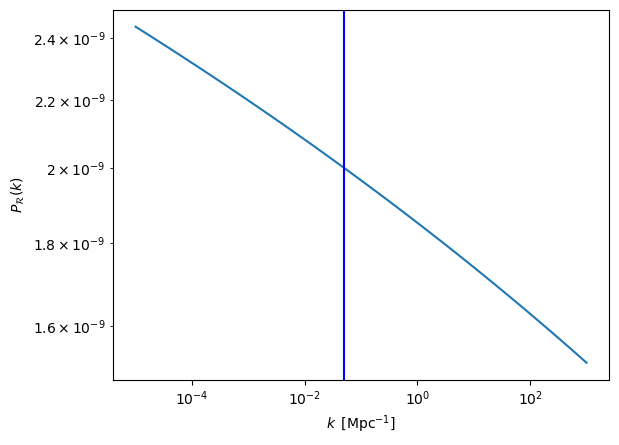

In [21]:
#Scalar PPS

R2 = sol[:,-1] * (Hubble_interp(N_win[:,-1]) / psi_interp(N_win[:,-1]) / aN(N_win[:,-1]))**2  #0 e-fold before the last value of N_win

plt.loglog(k_win, R2 * k_win**3 / (2 * np.pi**2))
plt.axvline(x = k_star, color = 'b', label = 'axvline - full height')
#plt.axhline(y = 1.05855106e-10, color = 'b', label = 'axvline - full height')
plt.ylabel(r'$P_{\cal R}(k)$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

In [22]:
#Values of the scalar PPS with the right renormalization

R2 * k_win**3 / (2 * np.pi**2)

array([2.43992429e-09, 2.42943703e-09, 2.41896111e-09, 2.40849894e-09,
       2.39801149e-09, 2.38757359e-09, 2.37714906e-09, 2.36673487e-09,
       2.35629827e-09, 2.34590909e-09, 2.33553314e-09, 2.32513359e-09,
       2.31478336e-09, 2.30444505e-09, 2.29411812e-09, 2.28376930e-09,
       2.27346897e-09, 2.26318137e-09, 2.25290663e-09, 2.24260903e-09,
       2.23236118e-09, 2.22212247e-09, 2.21189841e-09, 2.20165352e-09,
       2.19145552e-09, 2.18126907e-09, 2.17109580e-09, 2.16090412e-09,
       2.15075715e-09, 2.14062352e-09, 2.13050206e-09, 2.12036140e-09,
       2.11026753e-09, 2.10018654e-09, 2.09011728e-09, 2.08003027e-09,
       2.06998810e-09, 2.05995901e-09, 2.04991248e-09, 2.03991120e-09,
       2.02992229e-09, 2.01994660e-09, 2.00995280e-09, 2.00000688e-09,
       1.99006995e-09, 1.98014779e-09, 1.97021065e-09, 1.96031648e-09,
       1.95043539e-09, 1.94056660e-09, 1.93068371e-09, 1.92084559e-09,
       1.91101659e-09, 1.90117567e-09, 1.89137772e-09, 1.88159245e-09,
      

In [23]:
# solve tensor perturbations


Re_sol_t = np.zeros((k_num, N_num, 2))
Im_sol_t = np.zeros((k_num, N_num, 2))

def muksas(S, N):
    u, f = S

    return [f, (eps1n(N) - 1)*f + 1 / (aN(N) * Hubble_interp(N))**2 * (zeta_t(N) - k_win[i]**2)*u]

for i in range(k_num):
    Re_IC = [1 / np.sqrt(2 * k_win[i]), 0]
    Im_IC = [0, -np.sqrt(k_win[i] / 2) / (aN(N_win[i,0]) * Hubble_interp(N_win[i,0]))]

    Re_sol_t[i] = odeint(muksas, Re_IC, N_win[i])
    Im_sol_t[i] = odeint(muksas, Im_IC, N_win[i])
    
sol_t = Re_sol_t[:,:,0]**2 + Im_sol_t[:,:,0]**2

Text(0.5, 0, '$k\\, \\ [{\\rm Mpc^{-1}}]$')

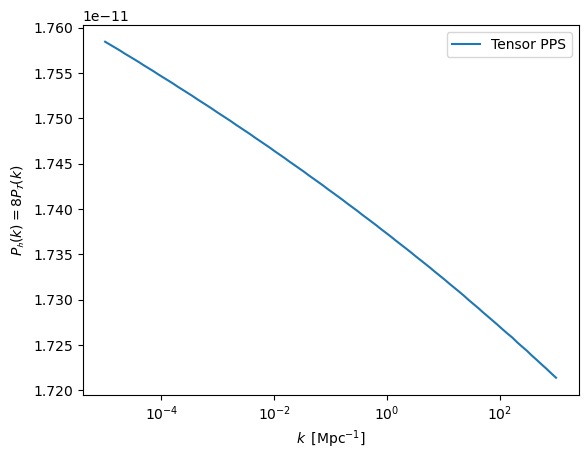

In [24]:
#Tensor PPS

h2 = sol_t[:,-1] * (1 / aN(N_win[:,-1]))**2

plt.plot(k_win, h2 * k_win**3 / (2 * np.pi**2) * 8 , label='Tensor PPS')
plt.xscale('log')
plt.legend()
plt.ylabel(r'$P_{\cal h}(k) = 8P_{\cal T}(k)$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

In [25]:
#Values of the tesnro PPS with the right renormalization:

h2 * k_win**3 / (2 * np.pi**2) * 8

array([1.75844316e-11, 1.75812838e-11, 1.75781258e-11, 1.75749482e-11,
       1.75715045e-11, 1.75683083e-11, 1.75650954e-11, 1.75618595e-11,
       1.75583680e-11, 1.75551167e-11, 1.75518456e-11, 1.75483083e-11,
       1.75450099e-11, 1.75417051e-11, 1.75383827e-11, 1.75347830e-11,
       1.75314365e-11, 1.75280693e-11, 1.75246931e-11, 1.75210359e-11,
       1.75176343e-11, 1.75142044e-11, 1.75107692e-11, 1.75070587e-11,
       1.75035881e-11, 1.75001076e-11, 1.74966041e-11, 1.74928352e-11,
       1.74893031e-11, 1.74857590e-11, 1.74821962e-11, 1.74783620e-11,
       1.74747652e-11, 1.74711552e-11, 1.74675252e-11, 1.74636271e-11,
       1.74599737e-11, 1.74562917e-11, 1.74523443e-11, 1.74486307e-11,
       1.74449081e-11, 1.74411614e-11, 1.74371450e-11, 1.74333665e-11,
       1.74295619e-11, 1.74257493e-11, 1.74216560e-11, 1.74178140e-11,
       1.74139421e-11, 1.74100360e-11, 1.74058815e-11, 1.74019644e-11,
       1.73980188e-11, 1.73937898e-11, 1.73898117e-11, 1.73858056e-11,
      

In [26]:
#Here we can further renormalize the scalar PPS coupling constant by looking at the ratio at 
#the pivot scale between the analytical and the numerical. 

PSs_interp_num = interp1d(k_win, R2 * k_win**3 / (2 * np.pi**2), kind='linear') # Interpolation to know the value 
                                                                                #of numerical PPS at the pivot scale

#We can further renormalize the scalar PPS by changing the coupling constant of the theory (in this case the mass), 
#from the ratio between numerical and analytical at the pivot scale k_star. 
#With this ratio we renormalize the masses used for the analytical PPS (m2an_s m2an_s_noeps4 and ):

Ratio_at_pivot_scalar_with_bs =( PSs_interp_num(k_star)/(loggPS_s3(k_star)) )
Ratio_at_pivot_scalar_with_bs_noeps4 =( PSs_interp_num(k_star)/(loggPS_s3_noeps4(k_star)) )

print("Ratio with eps4",Ratio_at_pivot_scalar_with_bs)
print("Ratio without eps4",Ratio_at_pivot_scalar_with_bs_noeps4)

Ratio with eps4 1.0000000000000002
Ratio without eps4 0.9999999999999992


In [27]:
#Check the value at the pivot scale

PSs_interp_num(k_star)

array(2.00000215e-09)

In [28]:
#Here we make a renormalization of the analytical tensorial PS in order to have the analytical and numerical PPS
#with the same values at the pivot scale. In this cas we renormalize the analytical coupling constant (m2an_t) in 
#the same way we have done above for the scalar, i.e. by multipling it for the ratio we obtain.

PSt_interp_num = interp1d(k_win, h2 * k_win**3 / (2 * np.pi**2) * 8, kind='linear')

Ratio_at_pivot_tensor_with_bs = (PSt_interp_num(k_star)/(loggPS_t3(k_star)))
Ratio_at_pivot_tensor_with_bs

1.0000000000000004

# Analytical vs numerical comparisons

Text(0.5, 0, '$k\\, \\ [{\\rm Mpc^{-1}}]$')

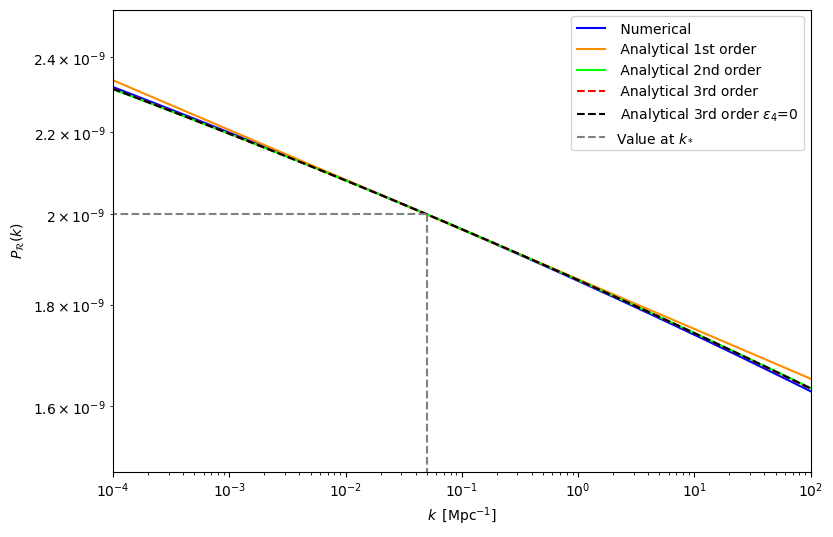

In [29]:
#Scalar PPS comparison

plt.figure(figsize=(9,6))
plt.loglog(k_win, PSs_interp_num(k_win), color="blue", label=" Numerical")
plt.loglog(k_win, loggPS_s1(k_win), color="darkorange", label = " Analytical 1st order")
plt.loglog(k_win, loggPS_s2(k_win), color="lime", label = " Analytical 2nd order")
plt.loglog(k_win, loggPS_s3(k_win), color="red", ls="--", label = " Analytical 3rd order")
plt.loglog(k_win, loggPS_s3_noeps4(k_win), color="k", ls="--", label = " Analytical 3rd order $\epsilon_4$=0")
plt.hlines(y = loggPS_s1(k_star),xmin= k_win[0], xmax=k_star , color = 'gray', label = 'Value at $k_*$', ls="--")
plt.vlines(x = k_star,ymin= 2*10**(-9), ymax=0 , color = 'gray', ls="--")
#plt.yticks(np.arange(2e-9, 5e-9,0.25e-9))
plt.xlim([10**(-4), 1e2])
plt.legend()
plt.ylabel(r'$P_{\cal R}(k)$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
#plt.savefig("Scalar PSs.pdf", format="pdf", dpi=400)

Text(0.5, 0, '$k\\, \\ [{\\rm Mpc^{-1}}]$')

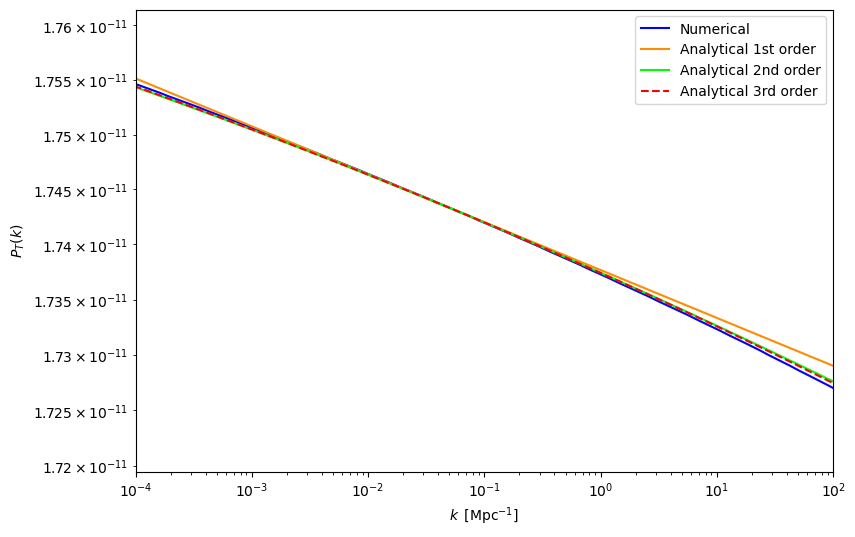

In [74]:
#Tensor PPS comparison

plt.figure(figsize=(9,6))
plt.loglog(k_win, PSt_interp_num(k_win) ,color="blue", label='Numerical')
plt.loglog(k_win, loggPS_t1(k_win), color="darkorange", label = "Analytical 1st order")
plt.loglog(k_win, loggPS_t2(k_win),color="lime",label = "Analytical 2nd order")
plt.loglog(k_win, loggPS_t3(k_win),color="red", ls="--", label = "Analytical 3rd order")
plt.xlim([10**(-4), 1e2])
plt.legend()
plt.xscale('log')
plt.ylabel(r'$P_{T}(k)$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
#plt.savefig("Tensor PSs.pdf", format="pdf", dpi=400)

In [75]:
# Percentage errors among the PPS

error_s1 = ((loggPS_s1(k_win))/PSs_interp_num(k_win) -1 )*100

error_s2 = ((loggPS_s2(k_win))/ PSs_interp_num(k_win) -1 )*100

error_s3 = ((loggPS_s3(k_win))/ PSs_interp_num(k_win) -1 )*100

error_s3_noeps4 = ((loggPS_s3_noeps4(k_win))/ PSs_interp_num(k_win) -1 )*100

error_t1 = ((loggPS_t1(k_win))/PSt_interp_num(k_win) -1 )*100

error_t2 = ((loggPS_t2(k_win))/PSt_interp_num(k_win)  -1 )*100

error_t3 = ((loggPS_t3(k_win))/PSt_interp_num(k_win)  -1 )*100

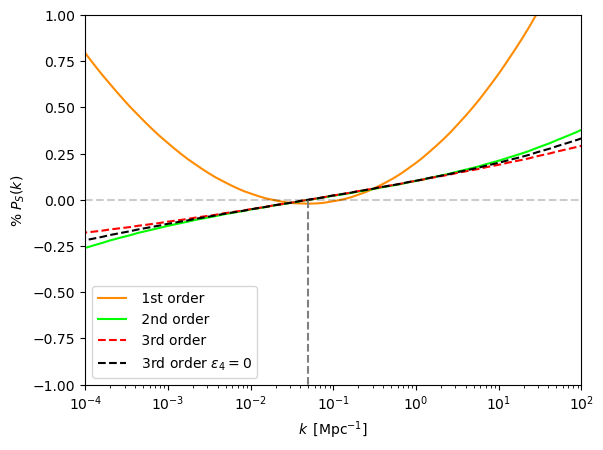

In [83]:
#Scalar PPS percentage errors

plt.plot(k_win, error_s1,color="darkorange", label = " 1st order")
plt.plot(k_win, error_s2,color="lime",label = " 2nd order")
plt.plot(k_win, error_s3,color="red",ls="--",label = " 3rd order")
plt.plot(k_win, error_s3_noeps4,color="k",ls="--",label = " 3rd order $\epsilon_4=0$")
plt.vlines(x = k_star,ymin= -10, ymax=0 , color = 'gray', ls="--")
plt.hlines(y = 0,xmin= 10**(-4), xmax=1e2 , color = 'k', ls="--",alpha=0.2)
plt.xscale('log')
plt.ylim([-1, +1])
plt.xlim([10**(-4), 1e2])
plt.ylabel(r'% $P_S(k)$ ')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()
#plt.savefig("Error scalar PSs.pdf", format="pdf", dpi=400)

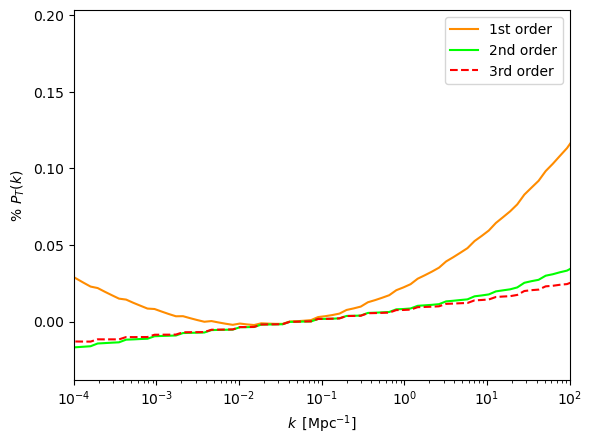

In [81]:
#Tensor PPS percentage errors

plt.plot(k_win, error_t1,color="darkorange", label = "1st order")
plt.plot(k_win, error_t2,color="lime",label = "2nd order")
plt.plot(k_win, error_t3,color="red",ls="--",label = "3rd order")
plt.xscale('log')
plt.xlim([10**(-4), 1e2])
plt.ylabel(r' % $P_T(k)$  ')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()
#plt.savefig("Error tensor PSS.pdf", format="pdf", dpi=400)

# $n_S$ and $n_T$ comparisions

In [85]:
# n_S, n_T analytical at second and third order

def n_s2_ana(ka): 
    log = np.log(ka/k_star)
    n_s2_value = 1+bs12(deltaN_star)+  bs22(deltaN_star)*log
    return n_s2_value

def n_t2_ana(ka): 
    log = np.log(ka/k_star)
    n_t2_value = bt12(deltaN_star)+  bt22(deltaN_star)*log
    return n_t2_value

def n_s3_ana(ka): 
    log = np.log(ka/k_star)
    log_sq= log**2
    n_s3_value = 1+bs13(deltaN_star)+  bs23(deltaN_star)*log + 0.5*bs33(deltaN_star)*log**2 
    return n_s3_value

def n_s3_ana_noeps4(ka): 
    log = np.log(ka/k_star)
    log_sq= log**2
    n_s3_value = 1+bs13(deltaN_star, False)+  bs23(deltaN_star, False)*log + 0.5*bs33(deltaN_star, False)*log**2 
    return n_s3_value

def n_t3_ana(ka): 
    log = np.log(ka/k_star)
    log_sq= log**2
    n_t3_value = bt13(deltaN_star)+  bt23(deltaN_star)*log + 0.5*bt33(deltaN_star)*log**2 
    return n_t3_value


In [86]:
#n_S and n_T numerical

#PPS and their logarithms
P_S = R2 * k_win**3 / (2 * np.pi**2)
P_h = h2 * k_win**3 / (2 * np.pi**2) * 8  
logPS = np.log(P_S)
logPT = np.log(P_h)
lnk=np.log(k_win/k_star)

#Spectral indices
n_S =1+ np.gradient(logPS, lnk)
n_T = np.gradient(logPT, lnk)

In [94]:
# Errors

ratio_nS_2 =(1- n_S / n_s2_ana(k_win))*100

ratio_nS_3 = (1- n_S / n_s3_ana(k_win))*100

ratio_nT_2 =(1- n_T / n_t2_ana(k_win))*100

ratio_nT_3 = (1- n_T / n_t3_ana(k_win))*100

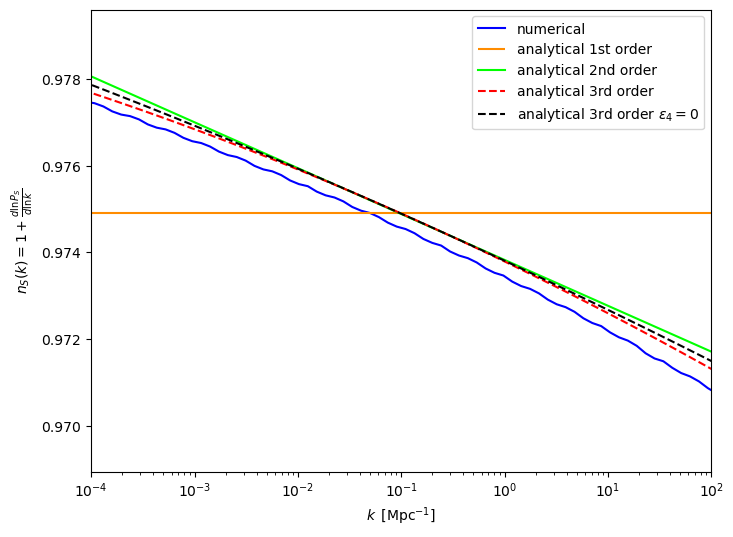

In [95]:
#n_S comparison

fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, n_S,color="blue", label="numerical")
plt.hlines(y = 1+bs11(deltaN_star),xmin= k_win[0], xmax=k_win[93] , color = 'darkorange', label = 'analytical 1st order', ls="-")
ax.plot(k_win, n_s2_ana(k_win),color="lime",label="analytical 2nd order" )
ax.plot(k_win, n_s3_ana(k_win),color="red", ls="--", label="analytical 3rd order")
ax.plot(k_win, n_s3_ana_noeps4(k_win),color="k", ls="--", label="analytical 3rd order $\epsilon_4 =0$")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$n_S(k) =1+\frac{d\ln P_S}{d \ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()
#plt.savefig("ns comparisons.pdf", format="pdf", dpi=400)


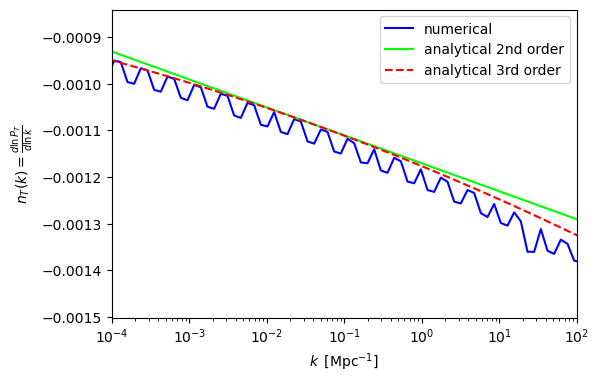

In [96]:
#n_T comparisons

fig, ax = plt.subplots(figsize=[6, 4])
ax.plot(k_win, n_T,color="blue", label="numerical")
ax.plot(k_win, n_t2_ana(k_win),color="lime",label="analytical 2nd order" )
ax.plot(k_win, n_t3_ana(k_win),color="red", ls="--", label="analytical 3rd order")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$n_T(k)=\frac{d\ln P_T}{d \ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()
#plt.savefig("nt comparisons.pdf", format="pdf", dpi=400)

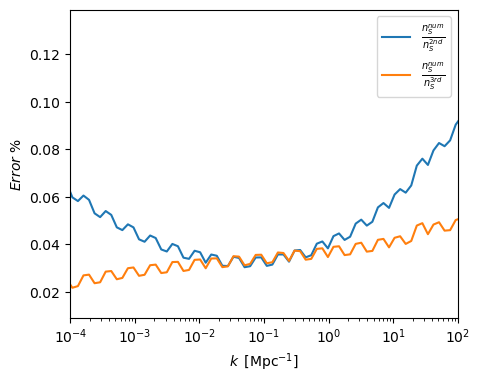

In [97]:
#n_S errors

fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, ratio_nS_2, label="$\\frac{n_S^{num}}{n_S^{2nd}}$")
ax.plot(k_win, ratio_nS_3,label="$\\frac{n_S^{num}}{n_S^{3rd }}$" )
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$Error \ \%$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()

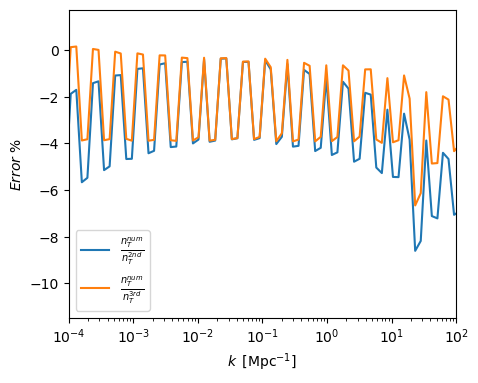

In [98]:
#n_T errors

fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, ratio_nT_2, label="$\\frac{n_T^{num}}{n_T^{2nd}}$")
ax.plot(k_win, ratio_nT_3,label="$\\frac{n_T^{num}}{n_T^{3rd}}$" )
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$Error \ \%$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()

# $\alpha_S$ and $\alpha_T$ comparisons

In [99]:
#alpha_S and alpha_T analytical

def alpha_s3_ana(ka): 
    log = np.log(ka/k_star)
    alpha_s3_value = bs23(deltaN_star) + bs33(deltaN_star)*log 
    return alpha_s3_value

def alpha_s3_ana_noeps4(ka): 
    log = np.log(ka/k_star)
    alpha_s3_value = bs23(deltaN_star, False) + bs33(deltaN_star, False)*log 
    return alpha_s3_value

def alpha_t3_ana(ka): 
    log = np.log(ka/k_star)
    alpha_t3_value = bt23(deltaN_star) + bt33(deltaN_star)*log
    return alpha_t3_value

In [100]:
#alpha_S and alpha_T numerical

alpha_S = np.gradient(n_S, lnk)
alpha_T = np.gradient(n_T, lnk)

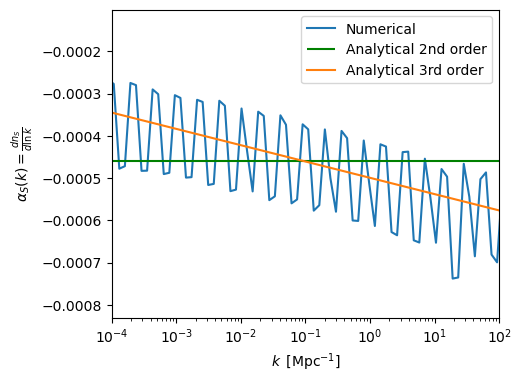

In [106]:
#\alpha_S comparison

fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, alpha_S, label ="Numerical")
plt.hlines(y = bs22(deltaN_star),xmin= k_win[0], xmax=k_win[93] , color = 'green', label = 'Analytical 2nd order', ls="-")
ax.plot(k_win, alpha_s3_ana(k_win), label = "Analytical 3rd order")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$\alpha_S(k)=\frac{d n_S}{d \ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()

Text(0.5, 0, '$k\\, \\ [{\\rm Mpc^{-1}}]$')

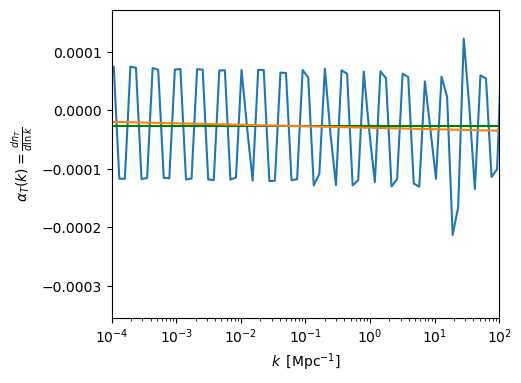

In [107]:
#\alpha_T comparison

fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, alpha_T)
plt.hlines(y = bt22(deltaN_star),xmin= k_win[0], xmax=k_win[93] , color = 'green', label = 'analytical 2nd order', ls="-")
ax.plot(k_win, alpha_t3_ana(k_win))
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$\alpha_T(k)=\frac{d n_T}{d \ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')

# Fitting $n_S$ and $n_T$

Cause the numerical resolution, the curves oscillates too much. We here perform a fitting of the spectra indices in $\ln\left(\frac{k}{k_*} \right)$ polynomials. 

In order to have $\beta_{S,T}$ not constant but at least linear in $\ln\left(\frac{k}{k_*} \right)$, we prefer to fit $n_S$ and $n_T$ at third order in $\ln\left(\frac{k}{k_*} \right)$.

In [108]:
#Fitting n_S and n_T

n_S_fitting_params = np.polyfit (np.log(k_win/k_star), n_S,3, rcond=None, full=False, w=None, cov=False)
print("n_S fitting parameters=",n_S_fitting_params)

n_T_fitting_params = np.polyfit (np.log(k_win/k_star), n_T,3, rcond=None, full=False, w=None, cov=False)
print("n_T fitting parameters=",n_T_fitting_params)

n_S fitting parameters= [-1.45370413e-07 -8.57060174e-06 -4.59754769e-04  9.74883579e-01]
n_T fitting parameters= [-1.48757939e-08 -6.16682364e-07 -2.77149713e-05 -1.11789123e-03]


In [109]:
n_S_fitted=+n_S_fitting_params[0]*np.log(k_win/k_star)**3+n_S_fitting_params[1]*np.log(k_win/k_star)**2+n_S_fitting_params[2]*np.log(k_win/k_star) +n_S_fitting_params[3]
n_T_fitted=+n_T_fitting_params[0]*np.log(k_win/k_star)**3+n_T_fitting_params[1]*np.log(k_win/k_star)**2+n_T_fitting_params[2] *np.log(k_win/k_star) +n_T_fitting_params[3]

alpha_S_fitted = np.gradient(n_S_fitted, lnk)
alpha_T_fitted = np.gradient(n_T_fitted, lnk)

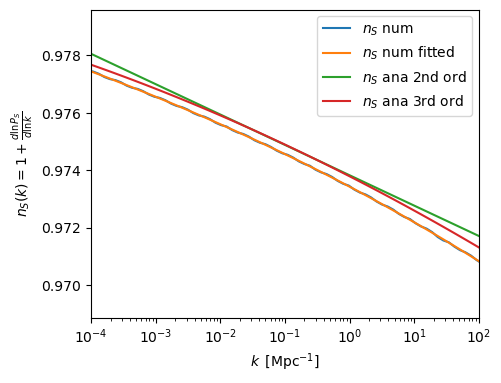

In [110]:
#n_S comparison

fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, n_S, label="$n_S$ num")
ax.plot(k_win, n_S_fitted, label="$n_S$ num fitted")
ax.plot(k_win, n_s2_ana(k_win), label= "$n_S$ ana 2nd ord"  )
ax.plot(k_win, n_s3_ana(k_win), label= "$n_S$ ana 3rd ord"  )
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$n_S(k) =1+\frac{d\ln P_S}{d \ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()

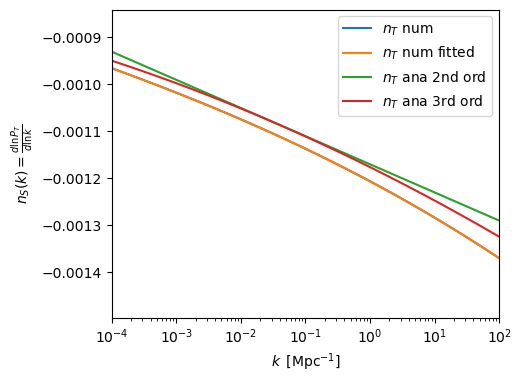

In [111]:
#n_T comparison

fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, n_T_fitted, label="$n_T$ num")
ax.plot(k_win, n_T_fitted, label="$n_T$ num fitted")
ax.plot(k_win, n_t2_ana(k_win),  label= "$n_T$ ana 2nd ord"  )
ax.plot(k_win, n_t3_ana(k_win),  label= "$n_T$ ana 3rd ord"  )
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$n_S(k) =\frac{d\ln P_T}{d \ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()

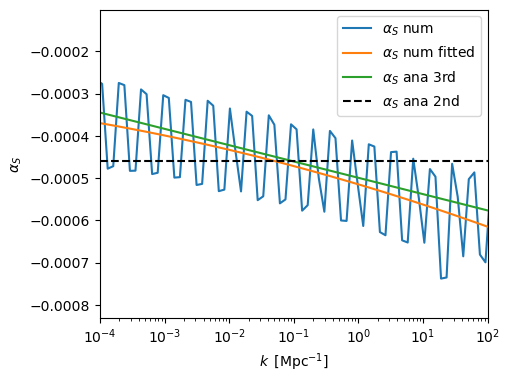

In [114]:
#alpha_S comparison
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win,alpha_S, label= "$\\alpha_S$ num")
ax.plot(k_win, alpha_S_fitted, label= "$\\alpha_S$ num fitted")
ax.plot(k_win, alpha_s3_ana(k_win), label= "$\\alpha_S$ ana 3rd")
ax.axhline(bs22(deltaN_star), xmin=k_win[0], xmax=k_win[93], color = "k", ls="--", label= "$\\alpha_S$ ana 2nd")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$\alpha_S$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
ax.legend()

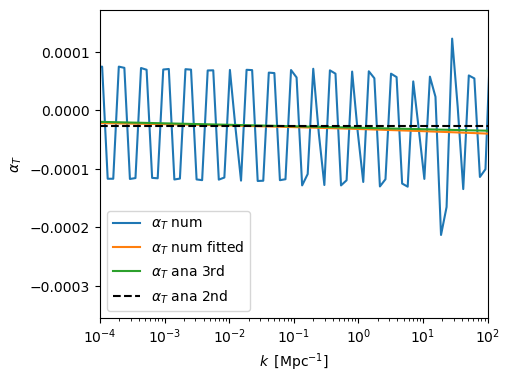

In [115]:
#alpha_T comparison

fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win,alpha_T, label= "$\\alpha_T$ num")
ax.plot(k_win, alpha_T_fitted, label= "$\\alpha_T$ num fitted")
ax.plot(k_win, alpha_t3_ana(k_win), label= "$\\alpha_T$ ana 3rd")
ax.axhline(bt22(deltaN_star), xmin=k_win[0], xmax=k_win[93], color = "k", ls="--", label= "$\\alpha_T$ ana 2nd")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$\alpha_T$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
ax.legend()

In [116]:
#beta_S and beta_T 

beta_S = np.gradient(alpha_S, lnk)
beta_T = np.gradient(alpha_T, lnk)

beta_S_fitted = np.gradient(alpha_S_fitted, lnk)
beta_T_fitted = np.gradient(alpha_T_fitted, lnk)

In [117]:
#Interpoltion of the fitted betas, just to find beta at k_star

beta_S_interp = interp1d(k_win,beta_S_fitted, kind='linear')
beta_T_interp = interp1d(k_win, beta_T_fitted, kind='linear')

In [118]:
print("beta_S(k_star) =", beta_S_interp(k_star))
print("beta_T(k_star) =", beta_T_interp(k_star))
print("Analytical beta_S(k_star) =",bs33(deltaN_star) )
print("Analytical beta_T(k_star) =", bt33(deltaN_star))

beta_S(k_star) = -1.7141194774108565e-05
beta_T(k_star) = -1.2333638376582614e-06
Analytical beta_S(k_star) = -1.676621820944202e-05
Analytical beta_T(k_star) = -1.0958023675737098e-06


# Errors of $n$ and $\alpha$

In [119]:
#Percentage errors

# n_S and n_T
ratio_nS_2 =(1-n_S / n_s2_ana(k_win))*100

ratio_nS_3 =(1- n_S / n_s3_ana(k_win))*100

ratio_nS_3_noeps4 =(1- n_S / n_s3_ana_noeps4(k_win))*100

ratio_nS_1_fit=(1- n_S_fitted /(1+bs11(deltaN_star)))*100

ratio_nS_2_fit =(1- n_S_fitted / n_s2_ana(k_win))*100

ratio_nS_3_fit = (1-n_S_fitted / n_s3_ana(k_win))*100

ratio_nS_3_fit_noeps4 = (1-n_S_fitted / n_s3_ana_noeps4(k_win))*100

ratio_nT_2 = (1-n_T / n_t2_ana(k_win))*100

ratio_nT_3 = (1- n_T / n_t3_ana(k_win))*100

ratio_nT_1_fit=(1- n_T_fitted /(bt11(deltaN_star)))*100

ratio_nT_2_fit = (1-n_T_fitted / n_t2_ana(k_win))*100

ratio_nT_3_fit = (1-n_T_fitted / n_t3_ana(k_win))*100


#alpha_S and alpha_T
ratio_alphaS_2 =(1- alpha_S/bs22(deltaN_star))*100

ratio_alphaS_3 =(1- alpha_S/alpha_s3_ana(k_win))*100

ratio_alphaS_3_noeps4 =(1- alpha_S/alpha_s3_ana_noeps4(k_win))*100

ratio_alphaS_2_fit =(1- alpha_S_fitted / bs22(deltaN_star))*100

ratio_alphaS_3_fit =(1- alpha_S_fitted / alpha_s3_ana(k_win))*100

ratio_alphaS_3_fit_noeps4 =(1- alpha_S_fitted / alpha_s3_ana_noeps4(k_win))*100

ratio_alphaT_2 = (1-alpha_T/bt22(deltaN_star))*100

ratio_alphaT_3 = (1-alpha_T/alpha_t3_ana(k_win))*100

ratio_alphaT_2_fit = (1-alpha_T_fitted / bt22(deltaN_star))*100

ratio_alphaT_3_fit = (1-alpha_T_fitted / alpha_t3_ana(k_win))*100

#beta_S and beta_T
ratio_betaS = (1-beta_S_fitted/bs33(deltaN_star))*100
ratio_betaS_noeps4 = (1-beta_S_fitted/bs33(deltaN_star, False))*100
ratio_betaT = (1-beta_T_fitted/bt33(deltaN_star))*100

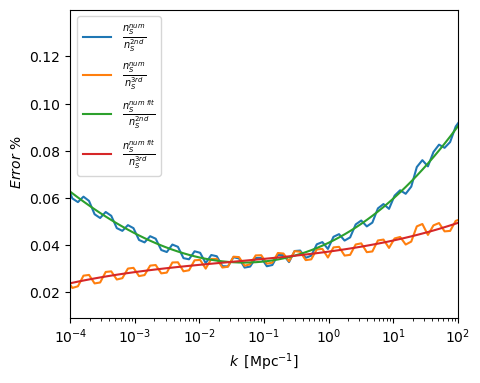

In [120]:
#n_S % errors

fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, ratio_nS_2, label="$\\frac{n_S^{num}}{n_S^{2nd}}$")
ax.plot(k_win, ratio_nS_3,label="$\\frac{n_S^{num}}{n_S^{3rd}}$" )
ax.plot(k_win, ratio_nS_2_fit,label="$\\frac{n_S^{num \ fit}}{n_S^{2nd}}$" )
ax.plot(k_win, ratio_nS_3_fit,label="$\\frac{n_S^{num \ fit}}{n_S^{3rd }}$" )
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$ \ Error \  \%$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()

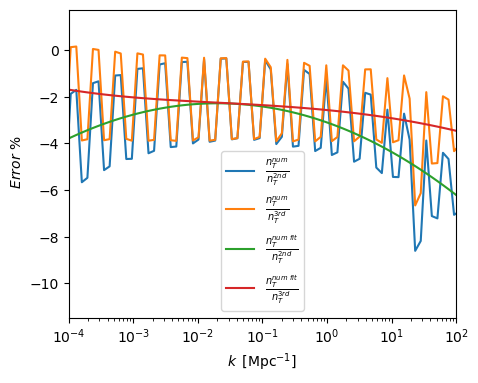

In [121]:
#n_T % errors

fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, ratio_nT_2, label="$\\frac{n_T^{num}}{n_T^{2nd}}$")
ax.plot(k_win, ratio_nT_3,label="$\\frac{n_T^{num}}{n_T^{3rd}}$" )
ax.plot(k_win, ratio_nT_2_fit,label="$\\frac{n_T^{num \ fit}}{n_T^{2nd}}$" )
ax.plot(k_win, ratio_nT_3_fit,label="$\\frac{n_T^{num \ fit}}{n_T^{3rd}}$" )
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$ \ Error \  \%$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()

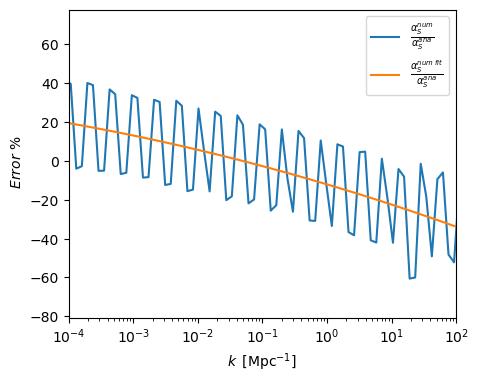

In [122]:
#alpha_S % errors

fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, ratio_alphaS_2, label="$\\frac{\\alpha_S^{num}}{\\alpha_S^{ana}}$")
ax.plot(k_win, ratio_alphaS_2_fit,label="$\\frac{\\alpha_S^{num \ fit}}{\\alpha_S^{ana}}$" )
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$ \ Error \  \%$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()

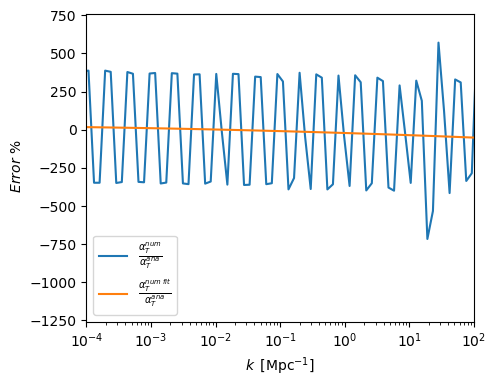

In [123]:
#alpha_T % errors


fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(k_win, ratio_alphaT_2, label="$\\frac{\\alpha_T^{num}}{\\alpha_T^{ana}}$")
ax.plot(k_win, ratio_alphaT_2_fit,label="$\\frac{\\alpha_T^{num \ fit}}{\\alpha_T^{ana}}$" )
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$ \ Error \  \%$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()

# Using the numerical fitted quantities

From here on, we will use the numerically fitted quantities as the proper numerical quantities. Since these are the final plots, we have also added another PyPPSinflation notebook to obtain these plots more quickly. We refer to that notebook for a better rapresentation of these plots.

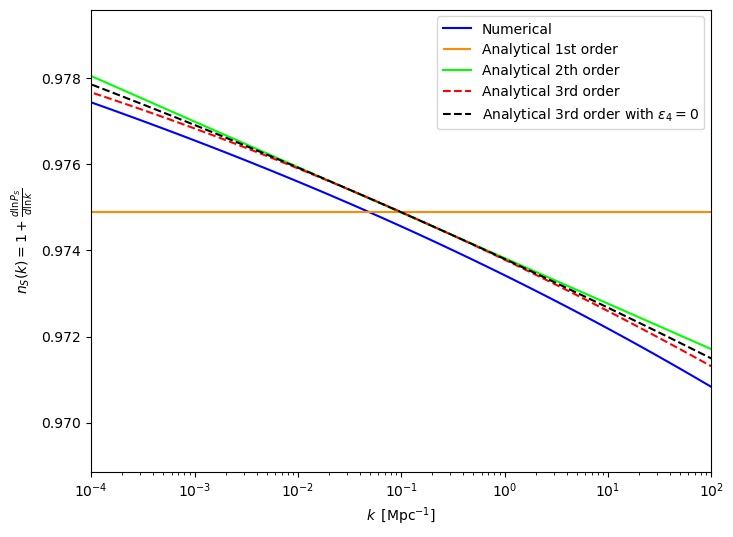

In [126]:
#n_S comparisons

fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, n_S_fitted,color="blue", label="Numerical")
plt.hlines(y = 1+bs11(deltaN_star),xmin= k_win[0], xmax=k_win[93] , color = 'darkorange', label = 'Analytical 1st order', ls="-")
ax.plot(k_win, n_s2_ana(k_win),color="lime",label="Analytical 2th order" )
ax.plot(k_win, n_s3_ana(k_win),color="red", ls="--", label="Analytical 3rd order")
ax.plot(k_win, n_s3_ana_noeps4(k_win),color="k", ls="--", label="Analytical 3rd order with $\epsilon_4=0$")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$n_S(k) =1+\frac{d\ln P_S}{d \ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()
#plt.savefig("ns comparisons.pdf", format="pdf", dpi=400)

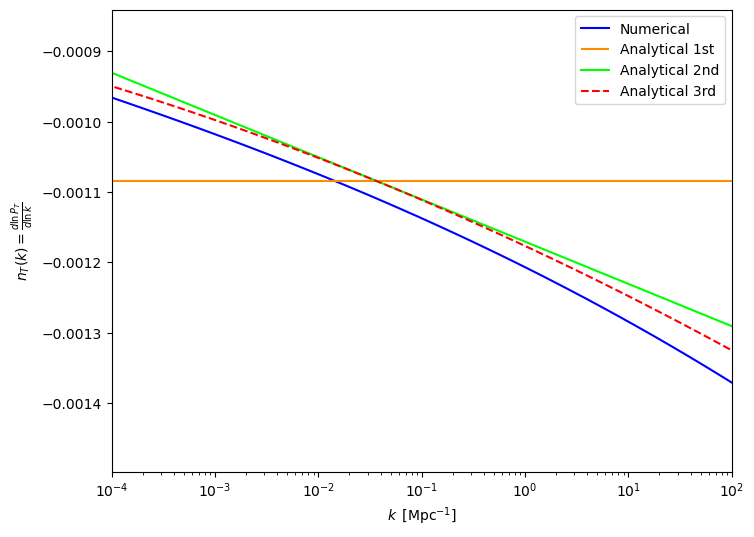

In [127]:
#n_T comparisons

fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, n_T_fitted,color="blue", label="Numerical")
plt.hlines(y = bt11(deltaN_star),xmin= k_win[0], xmax=k_win[93] , color = 'darkorange', label = 'Analytical 1st', ls="-")
ax.plot(k_win, n_t2_ana(k_win),color="lime",label="Analytical 2nd" )
ax.plot(k_win, n_t3_ana(k_win),color="red", ls="--", label="Analytical 3rd")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$n_T(k) =\frac{d\ln P_T}{d \ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()
#plt.savefig("nt comparisons.pdf", format="pdf", dpi=400)

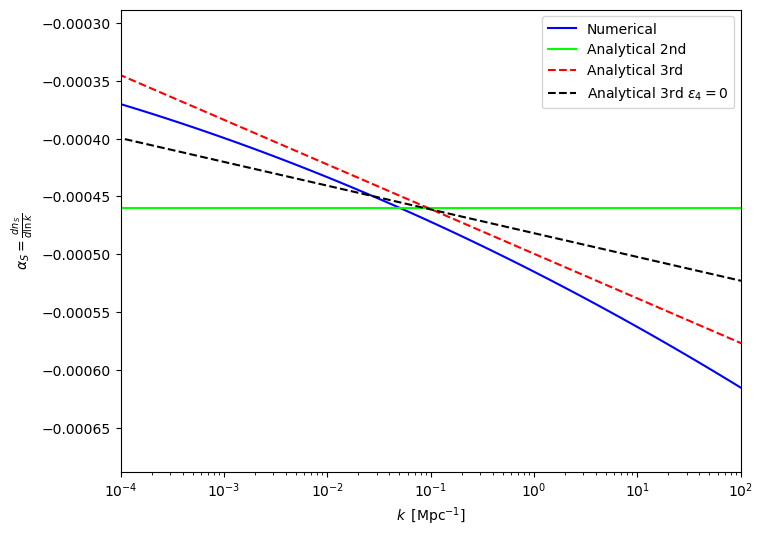

In [129]:
#alpha_S comparisons

fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, alpha_S_fitted, color="blue", label= "Numerical")
ax.axhline(bs22(deltaN_star), xmin=k_win[0], xmax=k_win[69], color = "lime", ls="-", label= "Analytical 2nd")
ax.plot(k_win, alpha_s3_ana(k_win),color="red",ls="--", label= "Analytical 3rd")
ax.plot(k_win, alpha_s3_ana_noeps4(k_win),color="k",ls="--", label= "Analytical 3rd $\epsilon_4=0$")
ax.set_xlim([1e-4,1e2])
ax.set_xscale('log')
plt.ylabel(r'$\alpha_S =\frac{dn_S}{d\ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
ax.legend()
#plt.savefig("alpha_S comparisons.pdf", format="pdf", dpi=400)

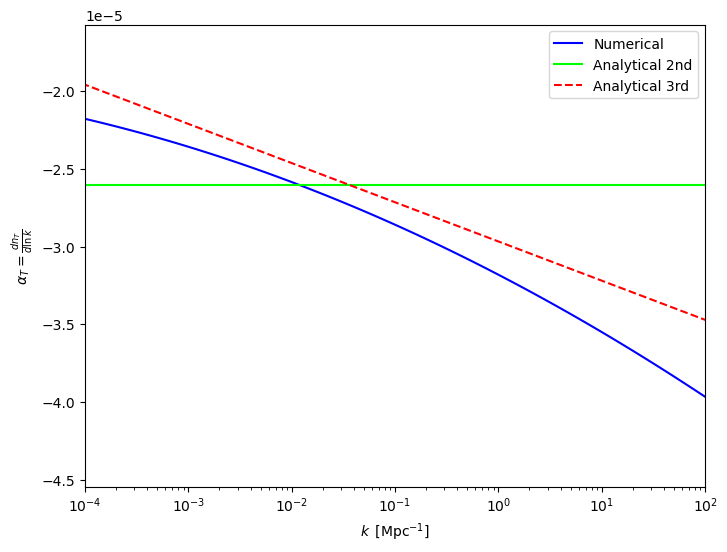

In [130]:
#alpha_T comparisons

fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, alpha_T_fitted, color="blue", label= "Numerical")
ax.axhline(bt22(deltaN_star), xmin=k_win[0], xmax=k_win[69], color = "lime", ls="-", label= "Analytical 2nd")
ax.plot(k_win, alpha_t3_ana(k_win),color="red",ls="--", label= "Analytical 3rd")
ax.set_xlim([1e-4,1e2])
ax.set_xscale('log')
plt.ylabel(r'$\alpha_T=\frac{dn_T}{d\ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
ax.legend()
#plt.savefig("alpha_T comparisons.pdf", format="pdf", dpi=400)

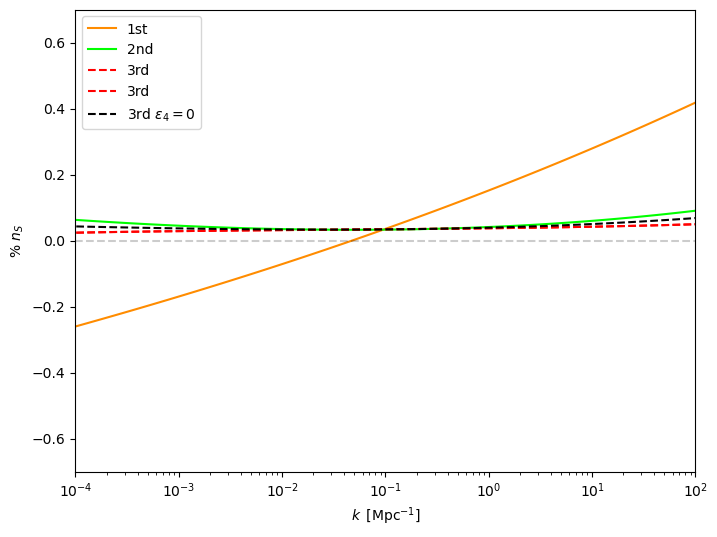

In [131]:
#n_S % errors

fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, ratio_nS_1_fit, color="darkorange",label="1st")
ax.plot(k_win, ratio_nS_2_fit,color="lime",label="2nd " )
ax.plot(k_win, ratio_nS_3_fit,color="red",ls="--",label="3rd" )
ax.plot(k_win, ratio_nS_3_fit,color="red",ls="--",label="3rd" )
ax.plot(k_win, ratio_nS_3_fit_noeps4,color="k",ls="--",label="3rd $\epsilon_4=0$" )
plt.hlines(y = 0,xmin= 10**(-4), xmax=1e2 , color = 'k', ls="--",alpha=0.2)
ax.set_xscale('log')
ax.set_ylim([-0.7,0.7])
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'% $ n_S$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()
#plt.savefig("n_S errors.pdf", format="pdf", dpi=400)

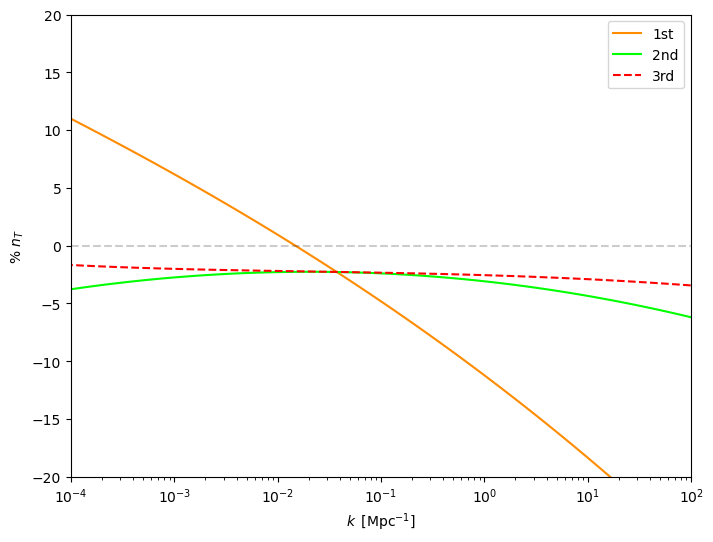

In [132]:
#n_T % errors

fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, ratio_nT_1_fit, color="darkorange",label="1st")
ax.plot(k_win, ratio_nT_2_fit,color="lime",label="2nd" )
ax.plot(k_win, ratio_nT_3_fit,color="red",ls="--",label="3rd" )
plt.hlines(y = 0,xmin= 10**(-4), xmax=1e2 , color = 'k', ls="--",alpha=0.2)
ax.set_xscale('log')
ax.set_ylim([-20,20])
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'% $ n_T$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()
#plt.savefig("n_T errors.pdf", format="pdf", dpi=400)

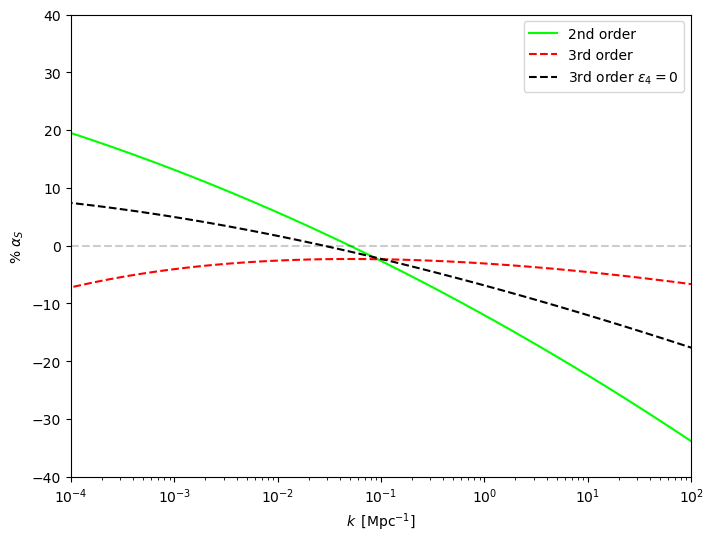

In [133]:
#alpha_S % errors
fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, ratio_alphaS_2_fit,color="lime",label="2nd order" )
ax.plot(k_win, ratio_alphaS_3_fit,color="red",ls="--",label="3rd order" )
ax.plot(k_win, ratio_alphaS_3_fit_noeps4,color="k",ls="--",label="3rd order $\epsilon_4=0$" )
plt.hlines(y = 0,xmin= 10**(-4), xmax=1e2 , color = 'k', ls="--",alpha=0.2)
ax.set_xscale('log')
ax.set_ylim([-40,40])
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'% $ \alpha_S$ ')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()
#plt.savefig("alpha_S errors.pdf", format="pdf", dpi=400)

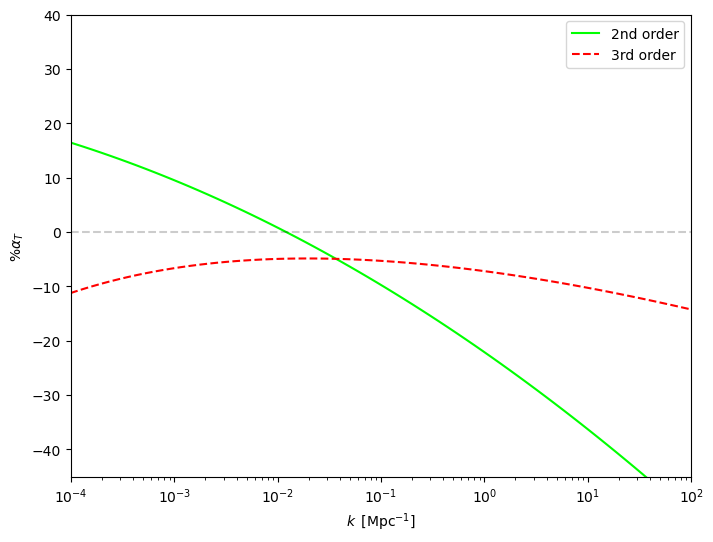

In [134]:
#alpha_T % errors

fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, ratio_alphaT_2_fit,color="lime",label="2nd order" )
ax.plot(k_win, ratio_alphaT_3_fit,color="red",ls="--",label="3rd order" )
plt.hlines(y = 0,xmin= 10**(-4), xmax=1e2 , color = 'k', ls="--",alpha=0.2)
ax.set_xscale('log')
ax.set_ylim([-45,40])
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'%$ \alpha_T$ ')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()
#plt.savefig("alpha_T errors.pdf", format="pdf", dpi=400)

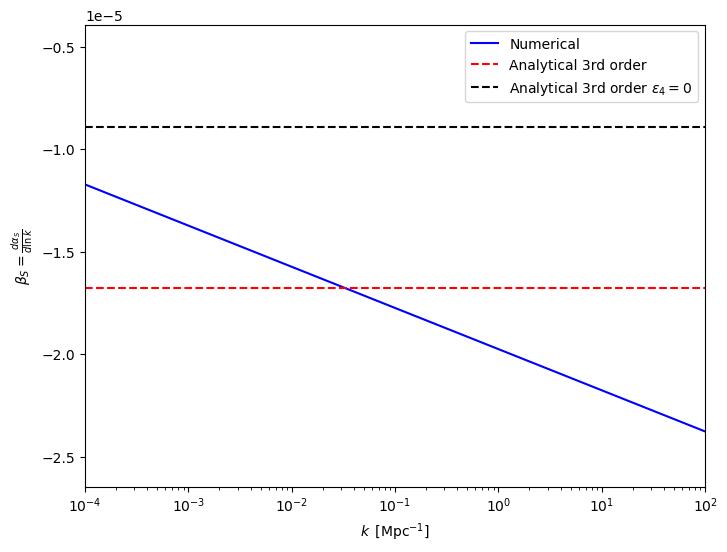

In [136]:
#beta_S comparison

fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, beta_S_fitted, color="blue", label= "Numerical")
ax.axhline(bs33(deltaN_star), xmin=k_win[0], xmax=k_win[93], color = "red", ls="--", label= "Analytical 3rd order")
ax.axhline(bs33(deltaN_star, False), xmin=k_win[0], xmax=k_win[93], color = "k", ls="--", label= "Analytical 3rd order $\epsilon_4=0$")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$\beta_S=\frac{d\alpha_S}{d\ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
ax.legend()
#plt.savefig("beta_S.pdf", format="pdf", dpi=400)

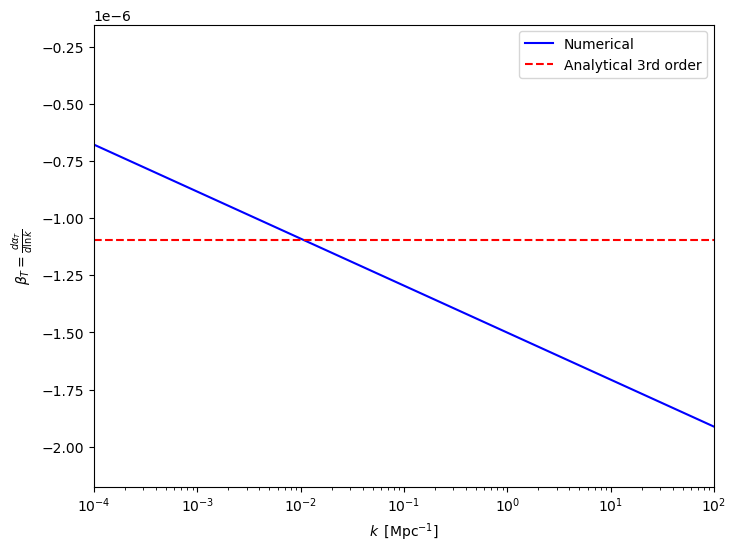

In [137]:
#beta_T comparison

fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, beta_T_fitted, color="blue", label= "Numerical")
ax.axhline(bt33(deltaN_star), xmin=k_win[0], xmax=k_win[69], color = "red", ls="--", label= "Analytical 3rd order")
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'$\beta_T=\frac{d\alpha_T}{d\ln k}$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
ax.legend()
#plt.savefig("beta_T.pdf", format="pdf", dpi=400)

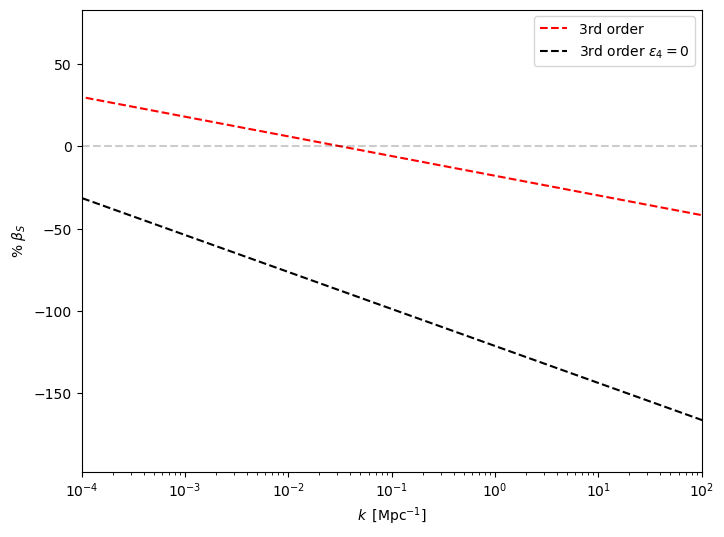

In [138]:
#beta_S % error

fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, ratio_betaS,color="red",ls="--",label="3rd order" )
ax.plot(k_win, ratio_betaS_noeps4,color="k",ls="--",label="3rd order $\epsilon_4=0$" )
plt.hlines(y = 0,xmin= 10**(-4), xmax=1e2 , color = 'k', ls="--",alpha=0.2)
ax.set_xscale('log')
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'% $ \beta_S$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()
#plt.savefig("beta_S errore.pdf", format="pdf", dpi=400)

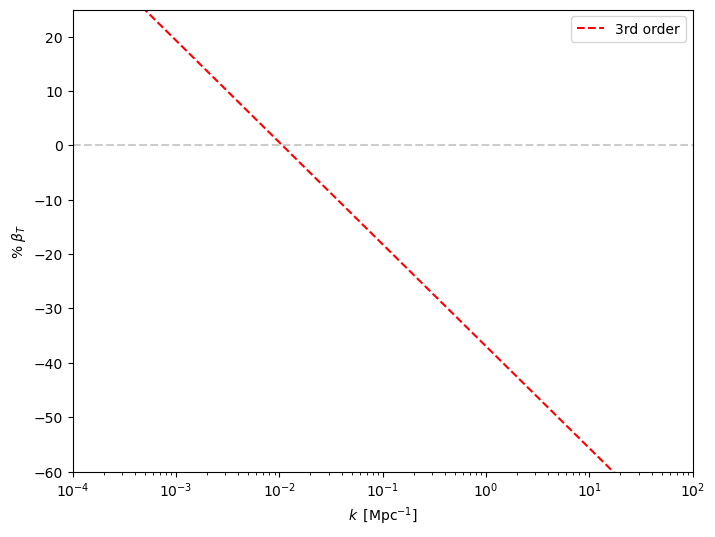

In [139]:
# beta_T % error

fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(k_win, ratio_betaT,color="red",ls="--",label="3rd order" )
plt.hlines(y = 0,xmin= 10**(-4), xmax=1e2 , color = 'k', ls="--",alpha=0.2)
ax.set_xscale('log')
ax.set_ylim([-60,25])
ax.set_xlim([1e-4,1e2])
plt.ylabel(r'% $ \beta_T$')
plt.xlabel(r'$k\, \ [{\rm Mpc^{-1}}]$')
plt.legend()
#plt.savefig("beta_T errore.pdf", format="pdf", dpi=400)